In [4]:
import glob
import re

import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from libpysal.graph import read_parquet

from core.utils import (
    char_units,
    used_keys,
)

regions_datadir = "/data/uscuni-ulce/"
data_dir = "/data/uscuni-ulce/processed_data/"
eubucco_files = glob.glob(regions_datadir + "eubucco_raw/*")
graph_dir = data_dir + "neigh_graphs/"
chars_dir = "/data/uscuni-ulce/processed_data/chars/"

In [2]:
# building_region_mapping = pd.read_parquet(regions_datadir + 'regions/' +'id_to_region.parquet', engine='pyarrow')
# counts = building_region_mapping.groupby('region')['id'].size()
# del building_region_mapping
# large_regions = counts[counts > 6e5].index
# large_regions

sdbAre                                     area of building
sdbPer                                perimeter of building
sdbCoA                           courtyard area of building
ssbCCo                     circular compactness of building
ssbCor                                  corners of building
                                ...                        
lskERI            equivalent rectangular index of enclosure
lskCWA               compactness-weighted axis of enclosure
ltkOri                             orientation of enclosure
ltkWNB           perimeter-weighted neighbours of enclosure
likWBB    total of building areas within the enclosure, ...
Length: 61, dtype: object

In [3]:
region_hulls = gpd.read_parquet(regions_datadir + "regions/" + "regions_hull.parquet")

In [4]:
def check_available():
    elements = ["buildings", "enclosures", "tessellations", "nodes", "streets"]
    for el in elements:
        el_ids = [
            int(re.findall(r"\d+", f)[0])
            for f in glob.glob(chars_dir + f"{el}/*.parquet")
        ]
        missing = np.setdiff1d(region_hulls.index.values, el_ids)
        print(f"Missing {el} for regions {missing}")


check_available()

Missing buildings for regions []
Missing enclosures for regions []
Missing tessellations for regions []
Missing nodes for regions []
Missing streets for regions []


In [5]:
# 12199 - hills, small test
# 69300 - prague medium
# 226 - germany somewhere, largest cluster

for region_id, region_hull in region_hulls.iterrows():
    if region_id != 69300:
        continue

    break
region_id

69300

### Merging data

In [6]:
tessellation = gpd.read_parquet(chars_dir + f"tessellations/chars_{region_id}.parquet")
buildings = gpd.read_parquet(chars_dir + f"buildings/chars_{region_id}.parquet")
enclosures = gpd.read_parquet(chars_dir + f"enclosures/chars_{region_id}.parquet")
streets = gpd.read_parquet(chars_dir + f"streets/chars_{region_id}.parquet")
nodes = gpd.read_parquet(chars_dir + f"nodes/chars_{region_id}.parquet")

In [7]:
tessellation.isna().sum(axis=1).describe()

count    322947.000000
mean          0.172802
std           0.564929
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           3.000000
dtype: float64

In [8]:
buildings.isna().sum(axis=1).describe()

count    298860.000000
mean          0.036519
std           0.328973
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           3.000000
dtype: float64

In [9]:
enclosures.isna().sum(axis=1).describe()

count    38062.000000
mean         0.650649
std          0.476771
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
dtype: float64

In [10]:
streets.isna().sum(axis=1).describe()

count    83094.000000
mean         0.891400
std          0.709006
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          3.000000
dtype: float64

In [11]:
nodes.isna().sum(axis=1).describe()

count    104666.000000
mean          0.964028
std           0.869168
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max           2.000000
dtype: float64

In [12]:
merged = pd.merge(
    tessellation.drop(columns=["geometry"]),
    buildings.drop(columns=["nodeID", "geometry"]),
    right_index=True,
    left_index=True,
    how="left",
)

merged = merged.merge(
    enclosures.drop(columns="geometry"),
    right_on="eID",
    left_on="enclosure_index",
    how="left",
)

merged = merged.merge(streets.drop(columns="geometry"), on="nID", how="left")
merged = merged.merge(nodes.drop(columns="geometry"), on="nodeID", how="left")

merged = merged.drop(
    columns=[
        "nID",
        "eID",
        "nodeID",
        "mm_len",
        "cdsbool",
        "node_start",
        "node_end",
        "x",
        "y",
        "enclosure_index",
        "id",
        "osm_id",
        "index",  ## maybe keep
    ]
)
merged = merged.set_index(tessellation.index)

In [14]:
# for c in merged.columns:
#     sns.histplot(data=merged, x=c)
#     plt.savefig(f'../data/plots/primary_{c}.png')
#     plt.figure()

In [23]:
merged.isna().sum(axis=1)

-24087     45
-24086     45
-24085     45
-24084     45
-24083     45
           ..
 298855     0
 298856     0
 298857     0
 298858     0
 298859     0
Length: 322947, dtype: int64

In [24]:
# merged.to_parquet(chars_dir + f'primary_chars/chars_{region_id}.parquet')

In [25]:
used_keys = pd.Series(used_keys)

char_units = pd.Series(char_units)
char_units.value_counts()

NameError: name 'used_keys' is not defined

In [17]:
# selected_cols = char_units[char_units == 'degrees'].index.values

selected_cols = list(used_keys.keys())

In [18]:
used_keys[selected_cols]

sdbAre                                     area of building
sdbPer                                perimeter of building
sdbCoA                           courtyard area of building
ssbCCo                     circular compactness of building
ssbCor                                  corners of building
                                ...                        
lskERI            equivalent rectangular index of enclosure
lskCWA               compactness-weighted axis of enclosure
ltkOri                             orientation of enclosure
ltkWNB           perimeter-weighted neighbours of enclosure
likWBB    total of building areas within the enclosure, ...
Length: 61, dtype: object

In [19]:
from sklearn.preprocessing import StandardScaler

In [20]:
# X_train = np.nan_to_num(StandardScaler().fit_transform(merged[selected_cols]))
# X_train = pd.DataFrame(X_train, columns=selected_cols)

### Context

In [27]:
# align indices

In [28]:
# tessellation = gpd.read_parquet(data_dir + f'/tessellations/tessellation_{region_id}.parquet')
# missing = np.setdiff1d(tessellation.index.values, merged.index.values)
# buff = pd.DataFrame(np.full((missing.shape[0], merged.shape[1]), np.nan), columns=merged.columns, index=missing)
# primary = pd.concat((merged, buff), axis=0).sort_index()

In [29]:
# subset = ['sdbAre', 'sdbCoA', 'ldsAre', 'sddAre', 'midAre', 'sdcAre',
#        'mdcAre', 'ldkAre']
# primary = primary.loc[:, primary.columns.isin(subset)]

In [32]:
primary = merged
primary.shape

(322947, 61)

In [33]:
@numba.njit(parallel=True)
def numba_limit_range(rows, cols, partial_vals, output_vals):
    # print(partial_vals)
    ngroups = int(rows[-1]) + 1
    nrows = rows.shape[0]
    result = np.empty((ngroups, partial_vals.shape[1] * output_vals))

    istart = 0
    for g in range(ngroups):
        # # find focal start
        # istart = 0
        # while istart < nrows and rows[istart] != g:
        #     istart += 1

        # find neighbors
        iend = istart + 1
        while iend < nrows and rows[iend - 1] == rows[iend]:
            iend += 1

        ## for every column apply iqr and percentiles
        for c in numba.prange(partial_vals.shape[1]):
            col_vals = partial_vals[cols[istart:iend], c]
            res_index = output_vals * c

            if np.isnan(col_vals).all():
                result[g, res_index] = np.nan
                result[g, res_index + 1] = np.nan
                result[g, res_index + 2] = np.nan
                continue

            lower, med, higher = np.nanpercentile(col_vals, (15, 50, 85))
            result[g, res_index] = lower
            result[g, res_index + 1] = med
            result[g, res_index + 2] = higher

        # # go to next group
        istart = iend
    return result

In [34]:
def parallel_higher_order_context(df, graph, k, n_splits, output_vals):
    A = graph.transform("B").sparse
    ids = graph.unique_ids.values
    rows = np.arange(A.shape[0])
    values = df.values

    final_result = pd.DataFrame(
        np.empty((values.shape[0], values.shape[1] * output_vals)), index=ids
    )

    for source in np.array_split(rows, n_splits):
        Q = A[source, :].copy()
        for _ in range(1, k):
            next_step = Q @ A
            Q += next_step

        sparray = Q.tocoo(copy=False)
        sorter = sparray.row.argsort()
        unique_tail = np.unique(sparray.col)
        partial_vals = values[unique_tail, :]

        cols_dict = pd.Series(np.arange(len(unique_tail)), index=unique_tail)
        columns_to_pass = cols_dict.loc[sparray.col].values
        rows_to_pass = sparray.row[sorter]

        partial_res = numba_limit_range(
            rows_to_pass, columns_to_pass, partial_vals, output_vals
        )

        final_result.iloc[source, :] = partial_res

    return final_result

In [35]:
graph = read_parquet(graph_dir + f"tessellation_graph_{region_id}_knn1.parquet")

In [29]:
# higher = graph.higher_order(k=2, lower_order=True, diagonal=True)

In [36]:
%%time
context = parallel_higher_order_context(primary, graph, k=7, n_splits=30, output_vals=3)

CPU times: user 19min 47s, sys: 27.5 s, total: 20min 14s
Wall time: 2min 23s


In [40]:
context.columns = np.concatenate(
    [(c + "_lower", c + "_median", c + "_higher") for c in primary.columns]
)

In [44]:
primary.columns

Index(['stcOri', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'mtcWNe', 'mdcAre',
       'ltcWRB', 'sicCAR', 'stcSAl', 'sdbAre', 'sdbPer', 'sdbCoA', 'ssbCCo',
       'ssbCor', 'ssbSqu', 'ssbERI', 'ssbElo', 'ssbCCM', 'ssbCCD', 'stbOri',
       'mtbSWR', 'libNCo', 'ldbPWL', 'ltcBuA', 'mtbAli', 'mtbNDi', 'ltbIBD',
       'stbCeA', 'stbSAl', 'ldkAre', 'ldkPer', 'lskCCo', 'lskERI', 'lskCWA',
       'ltkOri', 'ltkWNB', 'likWBB', 'sdsLen', 'sssLin', 'ldsMSL', 'ldsRea',
       'ldsAre', 'sisBpM', 'sdsSPW', 'sdsSPO', 'sdsSWD', 'mtdDeg', 'lcdMes',
       'linP3W', 'linP4W', 'linPDE', 'lcnClo', 'lddNDe', 'linWID', 'ldsCDL',
       'xcnSCl', 'mtdMDi', 'sddAre', 'midRea', 'midAre'],
      dtype='object')

In [195]:
# context.dropna(axis=0, how='all').shape[0], context.shape

In [196]:
desc = context.describe()

In [197]:
desc = context.describe()
desc.columns[desc.loc["max"] == desc.loc["min"]]

Index(['sdbCoA_lower', 'sdbCoA_median'], dtype='object')

In [170]:
# context = primary

In [32]:
X = np.nan_to_num(StandardScaler().fit_transform(context))
X = pd.DataFrame(X, columns=context.columns, index=context.index)

In [199]:
# X_train = X[X.index >=0]

In [200]:
# corrs = X.corr().abs()
# upper = corrs.where(np.triu(np.ones(corrs.shape), k=1).astype(bool))
# to_drop = [column for column in upper.columns if any(upper[column] > .85)]
# to_drop

In [201]:
# fig, ax = plt.subplots(figsize=(40, 40))
# sns.heatmap(corrs.round(1), cmap="vlag", center=0, annot=True, cbar=False)

In [202]:
# X = X.drop(to_drop, axis=1)

In [203]:
# X_train = X[X.index >=0]

In [204]:
# X = X.loc[:, X.columns.str.endswith('_median') | X.columns.str.endswith('_iqr')]

# X = X.loc[:, X.columns.str.endswith('_median')]

In [205]:
# X = np.nan_to_num(StandardScaler().fit_transform(primary))
# X = pd.DataFrame(X, columns=primary.columns, index=primary.index)

In [33]:
X_train = X

In [34]:
X_train.shape

(322947, 183)

In [ ]:
%%time
X_train = X_train.drop_duplicates()

### Kmeans


In [225]:
X_train = embedding

In [226]:
from sklearn.cluster import KMeans

In [227]:
for k in range(2, 30):
    kmeans_label = KMeans(n_clusters=k).fit(X_train).labels_
    ssplits = graph.describe(kmeans_label, statistics=["nunique"])["nunique"]
    print(
        k,
        " - ",
        adjusted_rand_score(tess_groups, kmeans_label[tess_groups_ilocs]),
        (ssplits > 1).sum() / ssplits.shape[0],
    )

2  -  -0.0009554646448578733 0.14714488755120808
3  -  0.14286740198367093 0.20113517078653773
4  -  0.1549476192636282 0.2385902330722998
5  -  0.21227837614220357 0.2573084747652091
6  -  0.18332345837420588 0.27126432510597714
7  -  0.21384276704633665 0.2820091222398722
8  -  0.26292909563868067 0.288768745335922
9  -  0.21364422100509506 0.2942835821357684
10  -  0.2570480820034711 0.3057219915342146
11  -  0.30196594771317725 0.3129646660287911
12  -  0.2709142878402248 0.31334862996095336
13  -  0.2622852070371841 0.31886656324412366
14  -  0.28699018397071524 0.31685075260027185
15  -  0.30442345835074874 0.32068110247192266
16  -  0.2907231918521774 0.3244897769603062
17  -  0.28665966496693923 0.32435972466070284
18  -  0.4286596717870844 0.33148473278897156
19  -  0.2971439588467953 0.3267223414368302
20  -  0.2900653147321691 0.3300108067268004
21  -  0.3321748056466855 0.3358074235091207
22  -  0.46708003052701613 0.33477319807894174
23  -  0.3990064421844456 0.33806166336

In [228]:
kmeans_label = KMeans(n_clusters=24).fit(X_train).labels_

In [229]:
clrs, clrs_counts = np.unique(kmeans_label, return_counts=True)

In [230]:
clrs_counts

array([20855, 13527, 13499,  7439,  7946,  9003,  8412, 16814, 10257,
       20778, 10512, 19304, 16167, 10784, 12956, 18217, 19488, 13514,
        2420, 19717, 16295, 11680,  2830, 20533])

In [285]:
def pprint_cluster_percentiles(X_train, labels):
    cluster_stats = X_train.groupby(labels).describe()
    cluster_stats = cluster_stats.loc[:, (slice(None), ["25%", "50%", "75%"])].T
    counts = X_train.groupby(labels).size()
    cluster_stats.loc[("count", "count"), :] = counts.values
    extended_col_names = {}
    for c in X_train.columns.values:
        if "_" in c:
            orig_key = c.split("_")[0]
            attach = c.split("_")[1]
            extended_col_names[c] = used_keys[orig_key] + " (" + attach + ")"
        else:
            extended_col_names[c] = used_keys[c]
    cluster_stats = cluster_stats.rename(extended_col_names, axis=0)
    f = {
        k: "{:.4f}" for k in cluster_stats.columns.values
    }  # column col A to 2 decimals
    return cluster_stats.style.format(f).background_gradient(axis=1, cmap="BuGn")

In [233]:
# pprint_cluster_percentiles(X_train, kmeans_label)

In [234]:
from lonboard import PolygonLayer
from lonboard.colormap import apply_categorical_cmap
from palettable.colorbrewer.qualitative import Set3_12

In [235]:
plotting = tessellation.copy()
plotting["label"] = kmeans_label

In [236]:
# plotting['centroid_x'] = plotting.geometry.centroid.x
# plotting['centroid_y'] = plotting.geometry.centroid.y
# plotting = plotting[['label', 'centroid_x', 'centroid_y', 'geometry', 'enclosure_index']]

In [237]:
plotting = plotting[["label", "geometry", "enclosure_index"]]

In [238]:
import glasbey


def hex_to_rgb(hexa):
    return tuple(int(hexa[i : i + 2], 16) for i in (0, 2, 4))


# gb_cols = [hex_to_rgb(c[1:]) for c in Set3_12.hex_colors]


gb_cols = glasbey.extend_palette(
    Set3_12.hex_colors, palette_size=plotting["label"].unique().shape[0] + 1
)
gb_cols = [hex_to_rgb(c[1:]) for c in gb_cols]

colors = apply_categorical_cmap(
    kmeans_label, cmap=dict(zip(np.unique(kmeans_label), gb_cols, strict=False))
)

In [239]:
layer = PolygonLayer.from_geopandas(gdf=plotting, get_fill_color=colors, opacity=0.15)

/home/krasen/miniconda3/envs/momepy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


In [241]:
# m = Map(layer, basemap_style=CartoBasemap.Positron)
# m

In [ ]:
malesice

### Sklearn agglomerative

In [80]:
X_train.duplicated().any()

False

In [95]:
from cluster_validation import (
    generate_enc_groups,
    get_tess_groups_original_ilocs,
    pprint_cluster_percentiles,
)

tess_groups = generate_enc_groups(tessellation, enclosures, include_random_sample=True)
tess_groups_ilocs = get_tess_groups_original_ilocs(tessellation, tess_groups)

In [112]:
from scipy.cluster.hierarchy import dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, davies_bouldin_score

In [84]:
clusterer = AgglomerativeClustering(
    linkage="single",
    # connectivity=graph.higher_order(k=3, lower_order=True).subgraph(buildings.index).transform('B').sparse,
    connectivity=graph.subgraph(X_train.index.values).transform("B").sparse,
    # connectivity=graph.higher_order(k=3, lower_order=True).transform('B').sparse,
    compute_full_tree=True,
    compute_distances=True,
)

In [85]:
%%time
model = clusterer.fit(X_train)

/home/krasen/miniconda3/envs/momepy/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:593: UserWarning: the number of connected components of the connectivity matrix is 180 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


CPU times: user 8min 27s, sys: 32 s, total: 8min 59s
Wall time: 32 s


In [341]:
# tessellation.iloc[np.where(graph.cardinalities == 1)].explore()

In [86]:
# tessellation[tessellation.enclosure_index == 36744]

In [87]:
# tessellation[tessellation.enclosure_index == 15509].explore()

In [88]:
def get_linkage_matrix(model):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    return linkage_matrix

In [89]:
linkage_matrix = get_linkage_matrix(model)

In [110]:
tess_groups = tess_groups[tess_groups.index.isin(X_train.index)]

In [113]:
for t in range(25, 1500, 50):
    r = fcluster(linkage_matrix, t=t, criterion="distance")
    r = pd.Series(r, index=X_train.index)
    # ssplits = graph.describe(r, statistics=['nunique'])['nunique']
    print(
        t,
        " - ",
        adjusted_rand_score(tess_groups, r.loc[tess_groups.index]),
        # (ssplits > 1).sum() / ssplits.shape[0],
        davies_bouldin_score(X_train, r),
    )

25  -  -7.517984782354125e-05 0.6700091121837655
75  -  -4.3772357334593385e-06 0.3686072576764354
125  -  0.0 0.37573411614791535
175  -  0.0 0.05591956782468782
225  -  0.0 0.03264023829374794
275  -  0.0 0.01322153462460506
325  -  0.0 0.01322153462460506
375  -  0.0 0.01322153462460506
425  -  0.0 0.01322153462460506
475  -  0.0 0.01322153462460506
525  -  0.0 0.01322153462460506
575  -  0.0 0.01322153462460506
625  -  0.0 0.01322153462460506


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

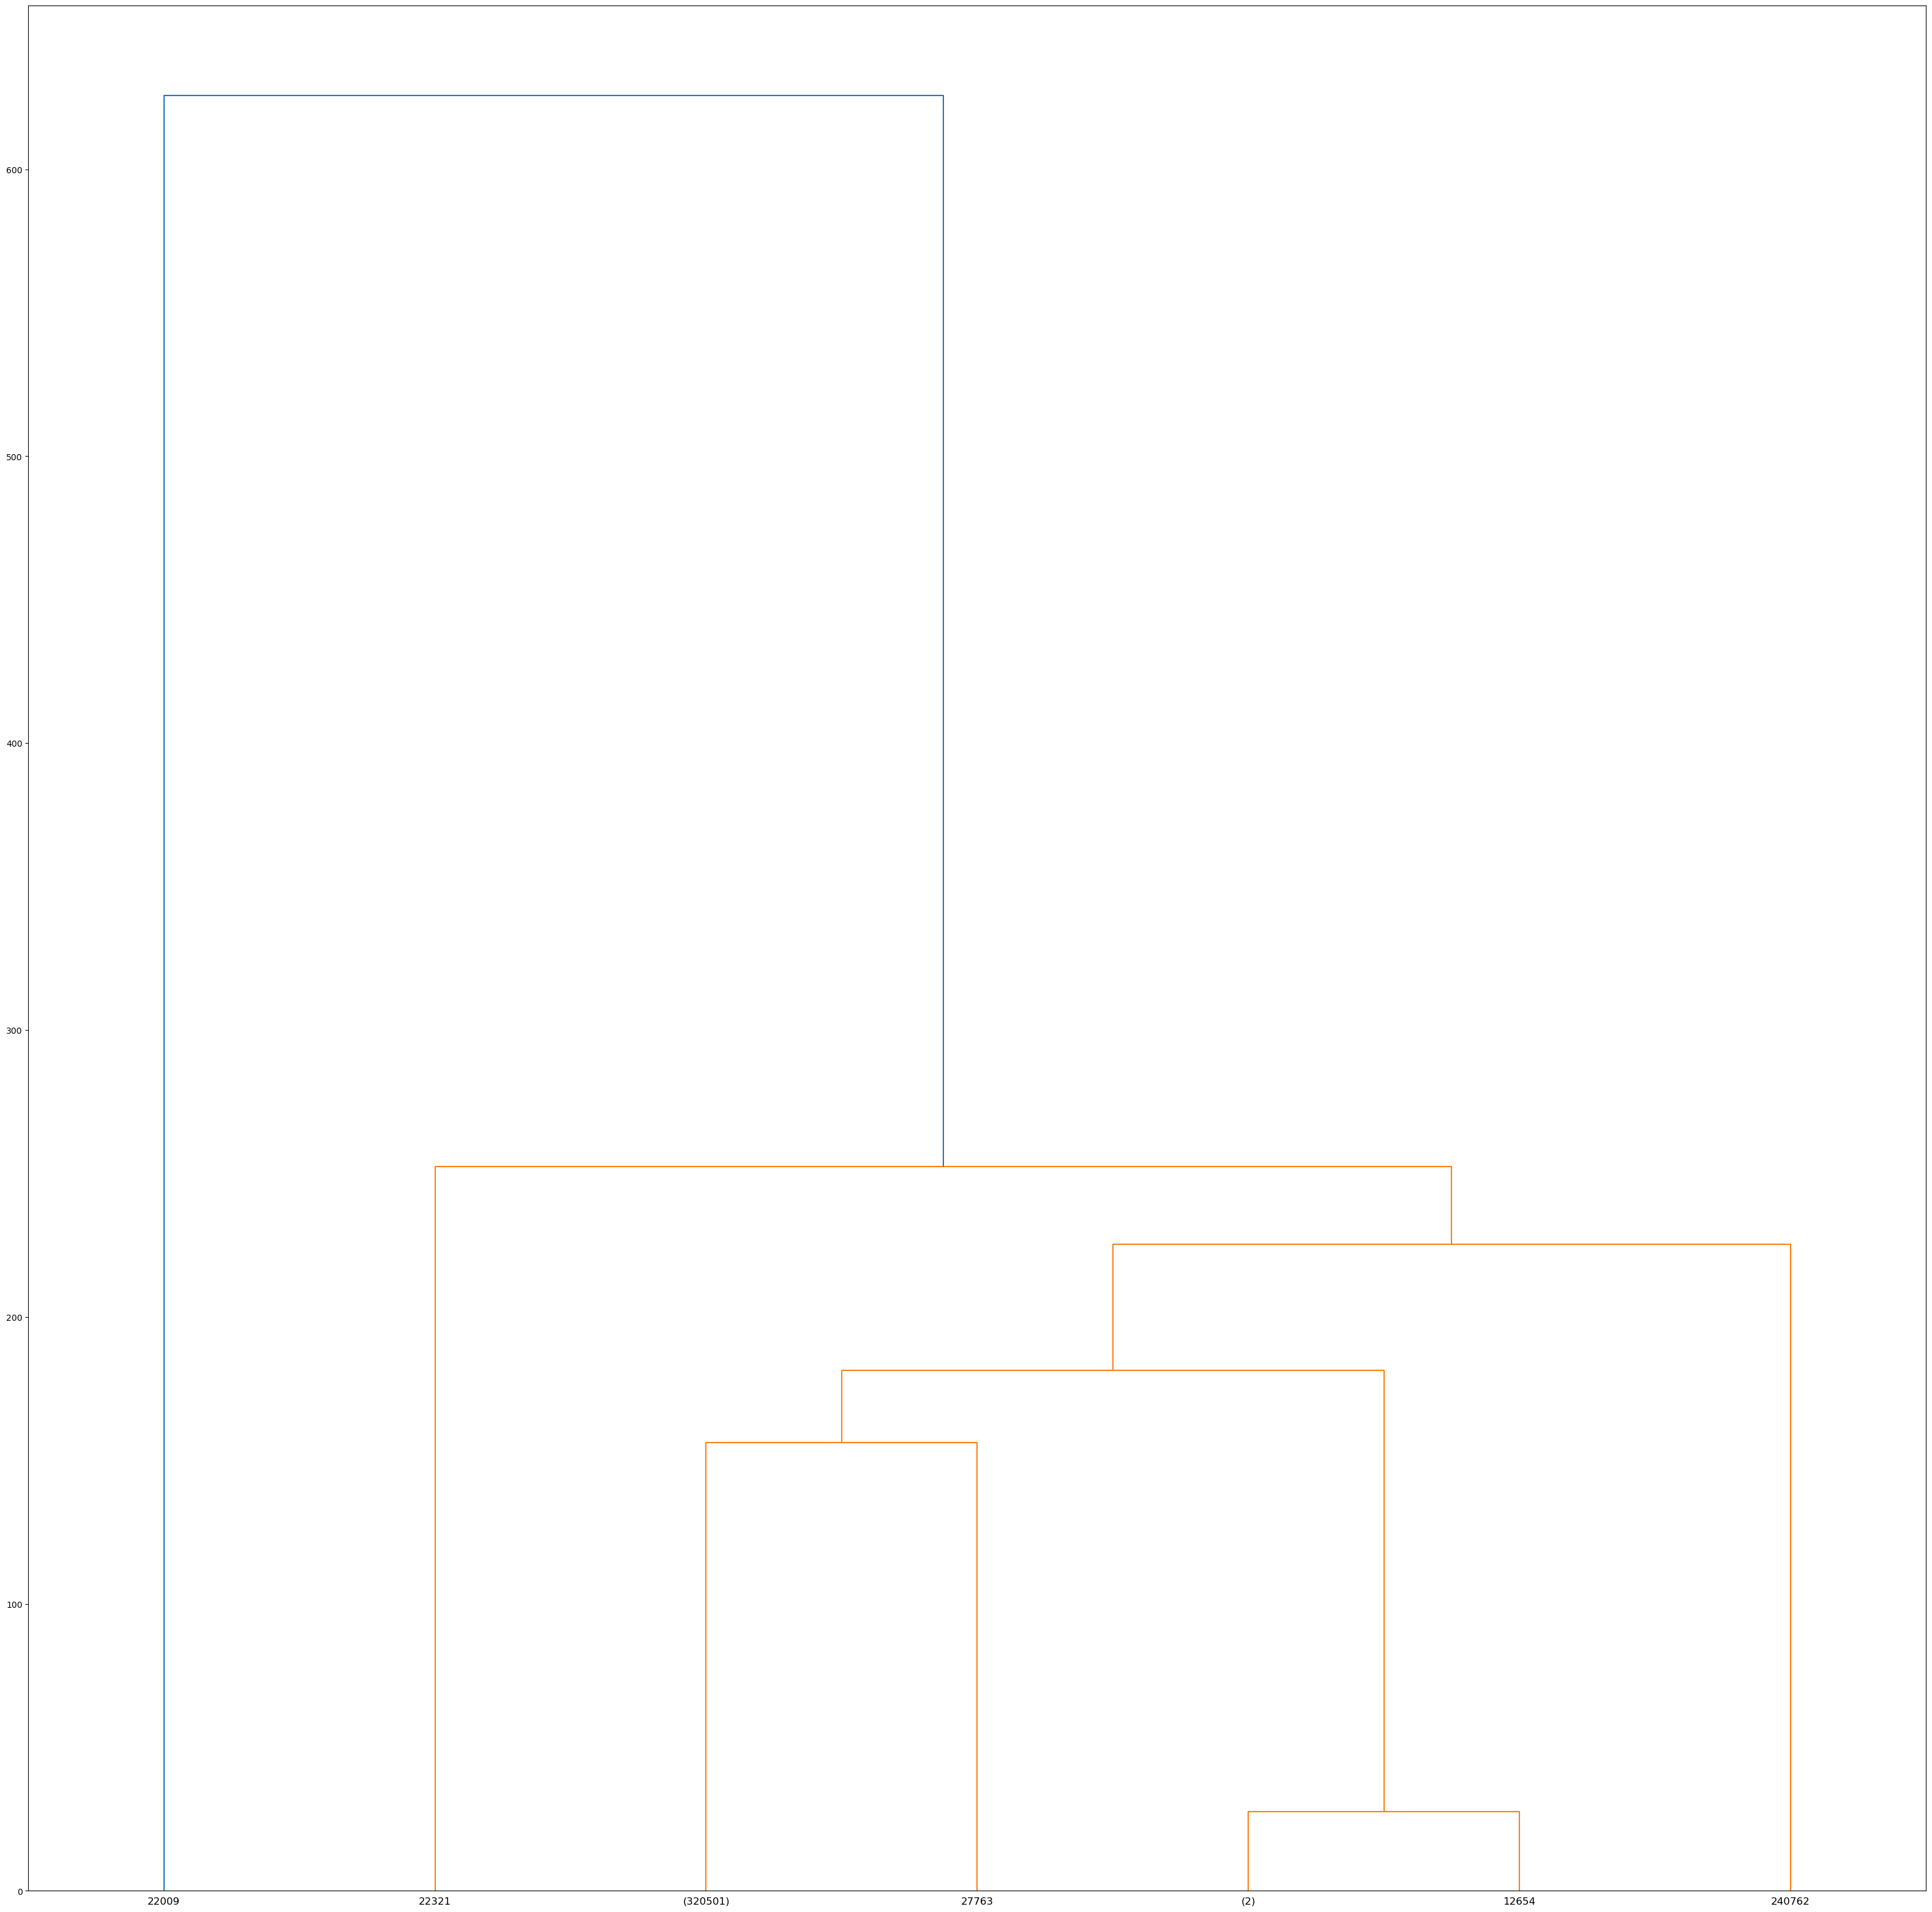

In [94]:
fix, ax = plt.subplots(figsize=(40, 40))
# Plot the corresponding dendrogram
_ = dendrogram(linkage_matrix, truncate_mode="level", p=4, ax=ax)

In [278]:
r = fcluster(linkage_matrix, t=1250, criterion="distance")

In [279]:
clrs, counts = np.unique(r, return_counts=True)
sorter = np.argsort(counts)[::-1]

In [280]:
clrs[sorter][:15], counts[sorter][:15]

(array([2, 1, 4, 3], dtype=int32), array([123308, 106700,  53613,  39326]))

In [281]:
clrs[-1]

4

In [290]:
pprint_cluster_percentiles(
    pd.DataFrame(X_train, columns=used_keys.iloc[[0, 1]].index.values), r
)

In [292]:
plotting = tessellation.copy()
plotting["label"] = r

In [293]:
import glasbey


def hex_to_rgb(hexa):
    return tuple(int(hexa[i : i + 2], 16) for i in (0, 2, 4))


# gb_cols = glasbey.extend_palette(Set3_12.hex_colors, palette_size=plotting['label'].unique().shape[0] + 1)
# gb_cols = [hex_to_rgb(c[1:]) for c in gb_cols]

gb_cols = [hex_to_rgb(c[1:]) for c in Set3_12.hex_colors]


colors = apply_categorical_cmap(
    plotting["label"], cmap=dict(zip(np.unique(plotting["label"]), gb_cols, strict=False))
)

In [294]:
layer = PolygonLayer.from_geopandas(
    gdf=plotting[["geometry", "label"]], get_fill_color=colors, opacity=0.15
)

/home/krasen/miniconda3/envs/momepy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


In [297]:
# m = Map(layer, basemap_style=CartoBasemap.Positron)
# m

### HDBSCAN

In [311]:
from fast_hdbscan.boruvka import parallel_boruvka
from fast_hdbscan.numba_kdtree import kdtree_to_numba
from sklearn.neighbors import KDTree

In [312]:
min_cluster_size = 25

In [485]:
%%time
sklearn_tree = KDTree(X_train)

CPU times: user 1.39 s, sys: 218 µs, total: 1.39 s
Wall time: 1.38 s


In [486]:
%%time
numba_tree = kdtree_to_numba(sklearn_tree)

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 12.2 µs


In [487]:
%%time
edges = parallel_boruvka(numba_tree, min_samples=min_cluster_size)

CPU times: user 5h 30min 35s, sys: 1.02 s, total: 5h 30min 36s
Wall time: 18min 45s


In [488]:
sorted_mst = edges[np.argsort(edges.T[2])]

In [313]:
from fast_hdbscan.boruvka import parallel_boruvka
from fast_hdbscan.cluster_trees import (
    cluster_tree_from_condensed_tree,
    condense_tree,
    extract_eom_clusters,
    get_cluster_label_vector,
    get_point_membership_strength_vector,
    mst_to_linkage_tree,
)
from fast_hdbscan.numba_kdtree import kdtree_to_numba
from sklearn.neighbors import KDTree

In [490]:
%%time
linkage_tree = mst_to_linkage_tree(sorted_mst)

CPU times: user 19.1 ms, sys: 0 ns, total: 19.1 ms
Wall time: 19.1 ms


In [314]:
%%time
linkage_tree = mst_to_linkage_tree(linkage_matrix[:, :3])

CPU times: user 123 ms, sys: 15 µs, total: 123 ms
Wall time: 122 ms


In [315]:
for mcs in range(25, 1200, 100):
    condensed_tree = condense_tree(linkage_tree, min_cluster_size=mcs)
    cluster_tree = cluster_tree_from_condensed_tree(condensed_tree)
    selected_clusters = extract_eom_clusters(
        condensed_tree, cluster_tree, allow_single_cluster=False
    )
    clusters = get_cluster_label_vector(condensed_tree, selected_clusters, 0)

    ssplits = graph.describe(clusters, statistics=["nunique"])["nunique"]
    print(
        mcs,
        " - ",
        adjusted_rand_score(tess_groups, clusters[blg_groups_locs]),
        (ssplits > 1).sum() / ssplits.shape[0],
        davies_bouldin_score(X_train, clusters),
    )

25  -  0.033707987702162295 0.7778366109609317 10.265763981661781
125  -  0.10136861486580426 0.47933561853802636 9.181071376294895
225  -  0.12039112317194026 0.3935630304662994 8.57678991613816
325  -  0.14417552312561174 0.33819481215183916 7.466703397555889
425  -  0.16940838904747443 0.3030930771922328 6.90106827590262
525  -  0.1740336822342479 0.2821144026728844 6.792668647496288
625  -  0.1785190415906218 0.2673070194180469 6.945164261695872
725  -  0.1967727619709728 0.25328614292747725 6.377978049358575
825  -  0.19853845387808128 0.2419561104453672 6.387575818858608
925  -  0.23086843897914805 0.22782066407181364 6.67680169180266
1025  -  0.23331051650106233 0.2170263232047364 6.793321101668001
1125  -  0.1894376624485858 0.21173443320420998 5.893711192150676


In [329]:
mcs = 125
condensed_tree = condense_tree(linkage_tree, min_cluster_size=mcs)

In [330]:
cluster_tree = cluster_tree_from_condensed_tree(condensed_tree)

In [331]:
selected_clusters = extract_eom_clusters(
    condensed_tree, cluster_tree, allow_single_cluster=False
)

In [332]:
# selected_clusters = extract_leaves(condensed_tree, False)

In [333]:
clusters = get_cluster_label_vector(condensed_tree, selected_clusters, 0)

In [334]:
membership_strengths = get_point_membership_strength_vector(
    condensed_tree, selected_clusters, clusters
)

In [335]:
np.unique(clusters, return_counts=True)

(array([  -1,    0,    1, ..., 1234, 1235, 1236]),
 array([36831,   215,   142, ...,   234,   270,   136]))

In [336]:
plotting = tessellation.copy()
plotting["label"] = clusters + 1

In [337]:
import glasbey


def hex_to_rgb(hexa):
    return tuple(int(hexa[i : i + 2], 16) for i in (0, 2, 4))


gb_cols = glasbey.extend_palette(
    Set3_12.hex_colors, palette_size=plotting["label"].unique().shape[0] + 1
)
gb_cols = [hex_to_rgb(c[1:]) for c in gb_cols]

# gb_cols = [hex_to_rgb(c[1:]) for c in Set3_12.hex_colors]


colors = apply_categorical_cmap(
    plotting["label"], cmap=dict(zip(np.unique(plotting["label"]), gb_cols, strict=False))
)

In [338]:
layer = PolygonLayer.from_geopandas(
    gdf=plotting[["geometry", "label"]], get_fill_color=colors, opacity=0.15
)

/home/krasen/miniconda3/envs/momepy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


In [340]:
# m = Map(layer, basemap_style=CartoBasemap.Positron)
# m

25 -- 2 : 0.7107610446787609
50 -- 2 : 1.0207205020632597
100 -- 2 : 0.9903180010914597


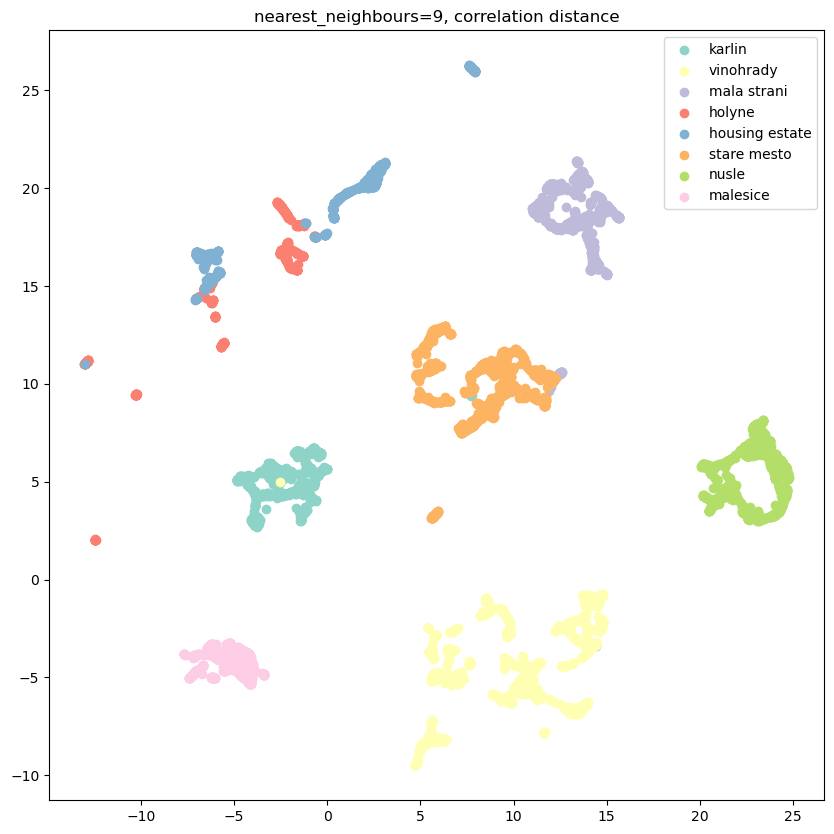

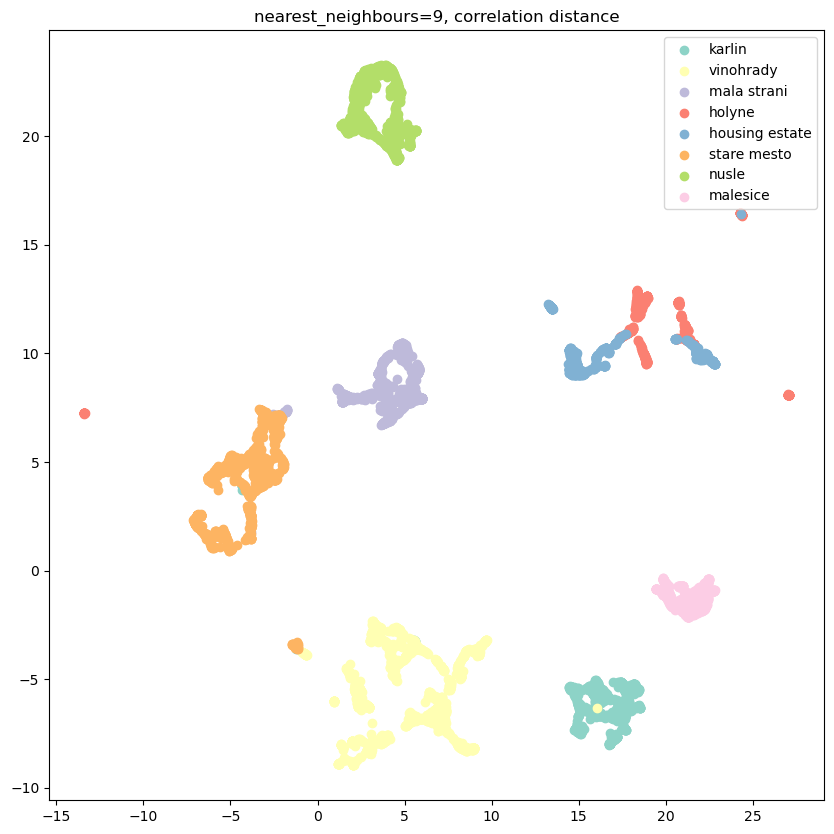

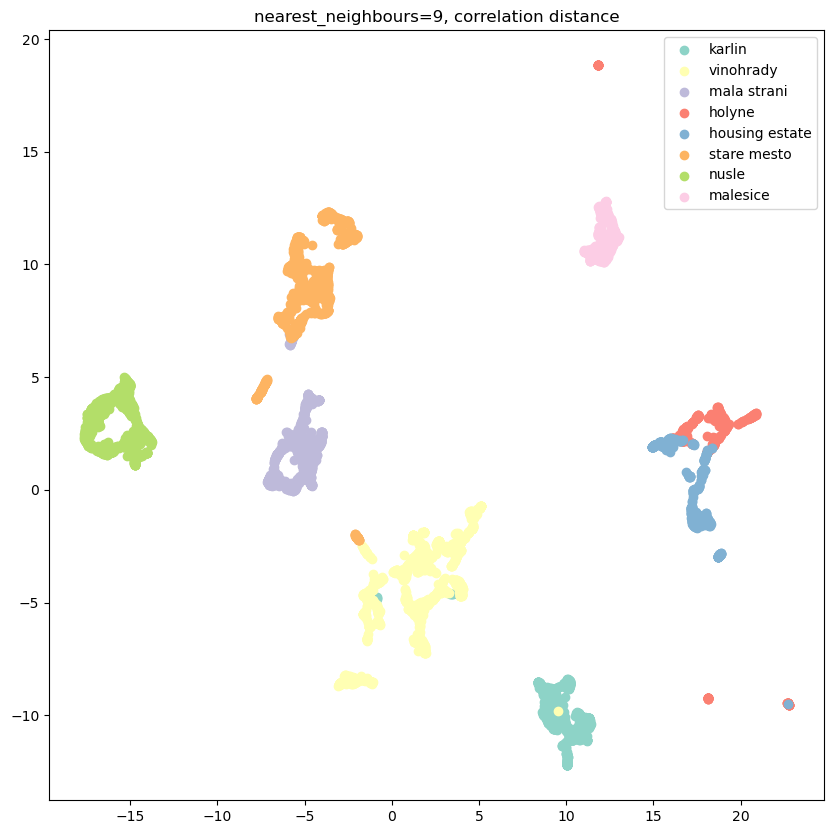

In [849]:
for nn in [25, 50, 100]:
    show_nn(nn, 2)

### Admin regions

In [109]:
import geopandas as gpd

In [110]:
czech_admin = gpd.read_file("data/MAP_CUR_MAP_MESTSKECASTI_P.zip")

In [24]:
czech_admin.explore()

In [697]:
admin_id, tess_id = tessellation.sindex.query(
    czech_admin.geometry.to_crs(tessellation.crs), predicate="intersects"
)

In [113]:
# czech_admin.explore()